In [6]:
from stable_baselines3.common.env_checker import check_env
from stable_baselines3 import PPO
from stable_baselines3 import SAC
from stable_baselines3.common.callbacks import EvalCallback

import os.path
import numpy as np
import pandas as pd
from tensorboardX import SummaryWriter

from lib_for_dqn import lifecycle

N_STEPS = 300_000

env = lifecycle.LifecycleEnv(consumption_shock = 0.5, 
    minimum_consumption = 0.1,
    equity_return = 0.05)
check_env(env)
model = PPO("MlpPolicy", env, seed = 0, 
            # learning_rate = 0.001,
            tensorboard_log="./runs/")

c:\Users\astragio\rep\Anaconda3\lib\site-packages\gym\spaces\box.py:73: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(


In [7]:
#if os.path.isfile("C:\\Users\\AS\\rep\\ucl_final_project\\life_sac.zip"):
# model = SAC.load("life_sac_v2", env=env)

eval_env = lifecycle.LifecycleEnv()
eval_callback = EvalCallback(eval_env, best_model_save_path='./logs/best_model', log_path='./logs/results', eval_freq=(N_STEPS/10))

model.learn(total_timesteps=N_STEPS, callback=eval_callback)
# model.save("life_sac_v2")

c:\Users\astragio\rep\ucl_final_project\reinforcement\lib_for_dqn\lifecycle.py:68: RuntimeWarning: divide by zero encountered in double_scalars
  "percent_consumption": (action_consumption / self.wealth),
c:\Users\astragio\rep\Anaconda3\lib\site-packages\stable_baselines3\common\evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=100000, episode_reward=39.23 +/- 1.78
Episode length: 77.00 +/- 3.74
New best mean reward!
Eval num_timesteps=200000, episode_reward=53.15 +/- 3.81
Episode length: 75.00 +/- 5.18
New best mean reward!
Eval num_timesteps=300000, episode_reward=45.31 +/- 17.81
Episode length: 68.40 +/- 10.65
Eval num_timesteps=400000, episode_reward=44.37 +/- 16.20
Episode length: 68.60 +/- 7.45
Eval num_timesteps=500000, episode_reward=59.12 +/- 13.51
Episode length: 76.60 +/- 3.83
New best mean reward!
Eval num_timesteps=600000, episode_reward=42.52 +/- 22.63
Episode length: 67.60 +/- 12.32
Eval num_timesteps=700000, episode_reward=54.06 +/- 14.21
Episode length: 75.60 +/- 5.20
Eval num_timesteps=800000, episode_reward=43.67 +/- 15.09
Episode length: 78.20 +/- 5.60
Eval num_timesteps=900000, episode_reward=59.59 +/- 17.62
Episode length: 71.40 +/- 8.43
New best mean reward!
Eval num_timesteps=1000000, episode_reward=59.03 +/- 5.81
Episode length: 78.40 +/- 3.88


In [8]:
# watch trained agent
rewards = 0
num_steps = env.terminal_age - env.starting_age + 1
info_df = pd.DataFrame(
    columns=("run", "age", "wealth", "percent_consumption", "consumption", "consumption_diff",
    "equity_allocation", "port_return", "reward"))

runs = 500
for run_number in range(runs):
    state = env.reset()
    done = False
    for step in range(num_steps):
        action, _states = model.predict(state, deterministic=True)
        state, reward, done, info = env.step(action)
        info.update(run = run_number) 
        #new_info = info.update(run = run_number) 
        # print(info)
        info_df.loc[len(info_df.index)] = info
        rewards += reward
info_df = info_df.groupby('age').mean()

c:\Users\astragio\rep\ucl_final_project\reinforcement\lib_for_dqn\lifecycle.py:68: RuntimeWarning: divide by zero encountered in double_scalars
  "percent_consumption": (action_consumption / self.wealth),
c:\Users\astragio\rep\ucl_final_project\reinforcement\lib_for_dqn\lifecycle.py:68: RuntimeWarning: divide by zero encountered in double_scalars
  "percent_consumption": (action_consumption / self.wealth),
c:\Users\astragio\rep\ucl_final_project\reinforcement\lib_for_dqn\lifecycle.py:68: RuntimeWarning: divide by zero encountered in double_scalars
  "percent_consumption": (action_consumption / self.wealth),
c:\Users\astragio\rep\ucl_final_project\reinforcement\lib_for_dqn\lifecycle.py:68: RuntimeWarning: divide by zero encountered in double_scalars
  "percent_consumption": (action_consumption / self.wealth),
c:\Users\astragio\rep\ucl_final_project\reinforcement\lib_for_dqn\lifecycle.py:68: RuntimeWarning: divide by zero encountered in double_scalars
  "percent_consumption": (action_con

Text(0.5, 1.0, 'Reward')

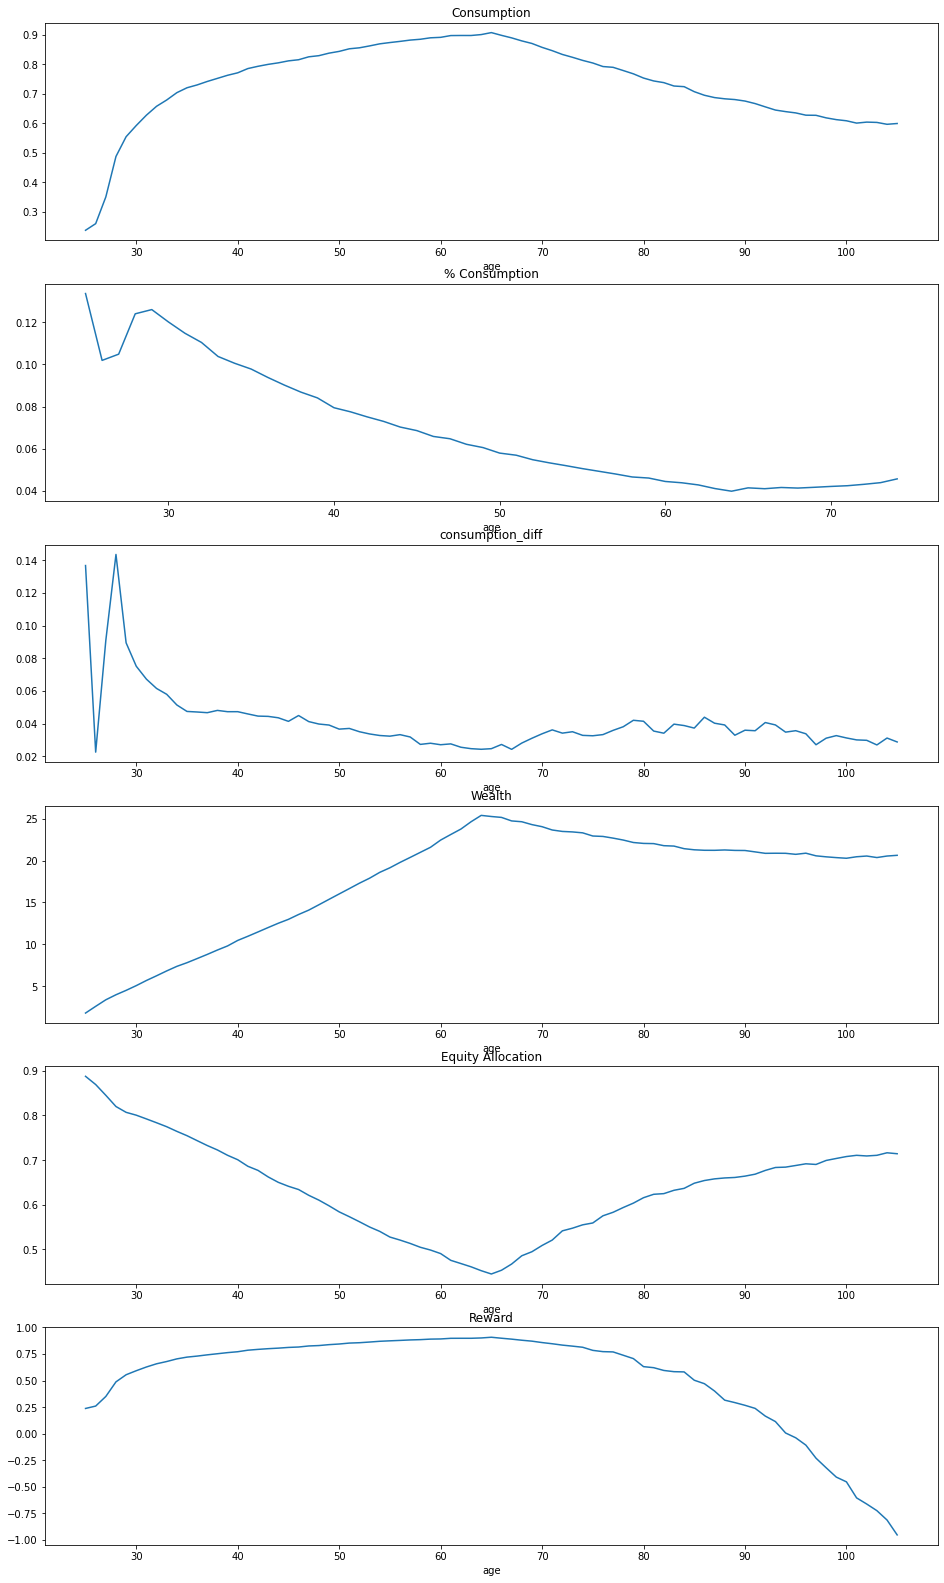

In [9]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(nrows = 6, figsize=(16, 28))
info_df.consumption.rename("consumption").plot(ax = ax[0])
ax[0].set_title("Consumption")
info_df.percent_consumption.rename("percent_consumption").plot(ax = ax[1])
ax[1].set_title("% Consumption")
info_df.consumption_diff.rename("consumption_diff").plot(ax = ax[2])
ax[2].set_title("consumption_diff")
info_df.wealth.plot(ax = ax[3])
ax[3].set_title("Wealth")
info_df.equity_allocation.plot(ax = ax[4])
ax[4].set_title("Equity Allocation")
info_df.reward.plot(ax = ax[5])
ax[5].set_title("Reward")

In [10]:
info_df

,run,wealth,percent_consumption,consumption,consumption_diff,equity_allocation,port_return,reward
age,,,,,,,,
25,249.5,1.788507,0.133592,0.236799,0.136799,0.887814,0.033157,0.236799
26,249.5,2.591064,0.101895,0.259278,0.022480,0.869378,0.039963,0.259278
27,249.5,3.372428,0.104844,0.349960,0.090939,0.845192,0.059344,0.349960
28,249.5,3.973649,0.123979,0.487367,0.143591,0.820054,0.029879,0.487367
29,249.5,4.498571,0.125981,0.554413,0.089444,0.807013,0.023128,0.554413
...,...,...,...,...,...,...,...,...
101,249.5,20.450628,NaN,0.600586,0.029977,0.710580,0.039795,-0.605723
102,249.5,20.536660,NaN,0.603950,0.029722,0.709134,0.042519,-0.663696
103,249.5,20.355583,NaN,0.602899,0.026887,0.710586,0.024302,-0.726086
